In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states, 
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA], #, model.d_optQ
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates, 
                                                                   model.training: True})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 gloss:1.0219 dlossA:1.6712 dlossQ:4.3125 exploreP:0.9980
Episode:1 meanR:22.0000 R:24.0000 rate:0.0480 gloss:1.0101 dlossA:1.6616 dlossQ:4.3332 exploreP:0.9957
Episode:2 meanR:25.3333 R:32.0000 rate:0.0640 gloss:0.8992 dlossA:1.6323 dlossQ:3.8439 exploreP:0.9925
Episode:3 meanR:25.5000 R:26.0000 rate:0.0520 gloss:1.0255 dlossA:1.6088 dlossQ:4.8900 exploreP:0.9900
Episode:4 meanR:26.6000 R:31.0000 rate:0.0620 gloss:0.9504 dlossA:1.5932 dlossQ:5.8639 exploreP:0.9869
Episode:5 meanR:25.3333 R:19.0000 rate:0.0380 gloss:0.6676 dlossA:1.5821 dlossQ:2.9088 exploreP:0.9851
Episode:6 meanR:23.8571 R:15.0000 rate:0.0300 gloss:1.4719 dlossA:1.5855 dlossQ:14.1730 exploreP:0.9836
Episode:7 meanR:23.8750 R:24.0000 rate:0.0480 gloss:0.7421 dlossA:1.5573 dlossQ:3.4824 exploreP:0.9813
Episode:8 meanR:24.7778 R:32.0000 rate:0.0640 gloss:0.8018 dlossA:1.5518 dlossQ:4.5131 exploreP:0.9782
Episode:9 meanR:24.7000 R:24.0000 rate:0.0480 gloss:0.7097 dlossA:1.5398

Episode:79 meanR:21.2375 R:19.0000 rate:0.0380 gloss:0.3361 dlossA:1.3612 dlossQ:2.3680 exploreP:0.8453
Episode:80 meanR:21.5309 R:45.0000 rate:0.0900 gloss:0.2859 dlossA:1.3445 dlossQ:2.0742 exploreP:0.8416
Episode:81 meanR:21.5610 R:24.0000 rate:0.0480 gloss:0.3253 dlossA:1.3473 dlossQ:2.3347 exploreP:0.8396
Episode:82 meanR:21.9398 R:53.0000 rate:0.1060 gloss:0.3085 dlossA:1.3460 dlossQ:2.2611 exploreP:0.8352
Episode:83 meanR:21.8571 R:15.0000 rate:0.0300 gloss:0.2995 dlossA:1.3432 dlossQ:2.1573 exploreP:0.8339
Episode:84 meanR:21.9176 R:27.0000 rate:0.0540 gloss:0.3203 dlossA:1.3387 dlossQ:2.1947 exploreP:0.8317
Episode:85 meanR:21.8372 R:15.0000 rate:0.0300 gloss:0.2613 dlossA:1.3386 dlossQ:2.0809 exploreP:0.8305
Episode:86 meanR:21.7586 R:15.0000 rate:0.0300 gloss:0.3018 dlossA:1.3404 dlossQ:2.1747 exploreP:0.8293
Episode:87 meanR:22.0455 R:47.0000 rate:0.0940 gloss:0.3129 dlossA:1.3461 dlossQ:2.3926 exploreP:0.8254
Episode:88 meanR:21.9775 R:16.0000 rate:0.0320 gloss:0.2923 dlos

Episode:158 meanR:28.0700 R:9.0000 rate:0.0180 gloss:0.2270 dlossA:1.3012 dlossQ:2.1121 exploreP:0.6690
Episode:159 meanR:28.3300 R:38.0000 rate:0.0760 gloss:0.1804 dlossA:1.2978 dlossQ:1.9734 exploreP:0.6665
Episode:160 meanR:28.5600 R:45.0000 rate:0.0900 gloss:0.1949 dlossA:1.2999 dlossQ:2.0676 exploreP:0.6635
Episode:161 meanR:28.9700 R:54.0000 rate:0.1080 gloss:0.1983 dlossA:1.2994 dlossQ:2.0215 exploreP:0.6600
Episode:162 meanR:28.9800 R:29.0000 rate:0.0580 gloss:0.1724 dlossA:1.2945 dlossQ:1.9966 exploreP:0.6581
Episode:163 meanR:29.3900 R:58.0000 rate:0.1160 gloss:0.1511 dlossA:1.2907 dlossQ:1.9708 exploreP:0.6544
Episode:164 meanR:29.2800 R:18.0000 rate:0.0360 gloss:0.2417 dlossA:1.3104 dlossQ:2.2132 exploreP:0.6532
Episode:165 meanR:29.4400 R:35.0000 rate:0.0700 gloss:0.2280 dlossA:1.3040 dlossQ:2.1093 exploreP:0.6510
Episode:166 meanR:29.5500 R:22.0000 rate:0.0440 gloss:0.1476 dlossA:1.2967 dlossQ:2.0089 exploreP:0.6496
Episode:167 meanR:29.4000 R:20.0000 rate:0.0400 gloss:0.

Episode:236 meanR:57.5100 R:76.0000 rate:0.1520 gloss:0.2582 dlossA:1.3107 dlossQ:2.0428 exploreP:0.4069
Episode:237 meanR:58.3400 R:109.0000 rate:0.2180 gloss:0.2496 dlossA:1.3094 dlossQ:2.0185 exploreP:0.4026
Episode:238 meanR:60.5900 R:262.0000 rate:0.5240 gloss:0.2455 dlossA:1.3067 dlossQ:2.0303 exploreP:0.3925
Episode:239 meanR:62.3300 R:190.0000 rate:0.3800 gloss:0.2577 dlossA:1.3180 dlossQ:2.0257 exploreP:0.3853
Episode:240 meanR:64.0000 R:189.0000 rate:0.3780 gloss:0.2646 dlossA:1.3179 dlossQ:2.0182 exploreP:0.3783
Episode:241 meanR:64.9900 R:141.0000 rate:0.2820 gloss:0.2720 dlossA:1.3211 dlossQ:2.0145 exploreP:0.3731
Episode:242 meanR:65.0200 R:17.0000 rate:0.0340 gloss:0.2922 dlossA:1.3151 dlossQ:2.0528 exploreP:0.3725
Episode:243 meanR:66.9000 R:204.0000 rate:0.4080 gloss:0.2678 dlossA:1.3157 dlossQ:1.9950 exploreP:0.3652
Episode:244 meanR:66.9800 R:31.0000 rate:0.0620 gloss:0.2706 dlossA:1.3282 dlossQ:2.0207 exploreP:0.3641
Episode:245 meanR:67.6400 R:119.0000 rate:0.2380 

Episode:314 meanR:175.6600 R:112.0000 rate:0.2240 gloss:0.3941 dlossA:1.3770 dlossQ:1.8267 exploreP:0.0939
Episode:315 meanR:178.8400 R:341.0000 rate:0.6820 gloss:0.3994 dlossA:1.3800 dlossQ:1.8433 exploreP:0.0911
Episode:316 meanR:179.5300 R:97.0000 rate:0.1940 gloss:0.4338 dlossA:1.3761 dlossQ:1.9036 exploreP:0.0903
Episode:317 meanR:180.8500 R:153.0000 rate:0.3060 gloss:0.4192 dlossA:1.3800 dlossQ:1.8663 exploreP:0.0891
Episode:318 meanR:182.5800 R:199.0000 rate:0.3980 gloss:0.4247 dlossA:1.3821 dlossQ:1.8317 exploreP:0.0875
Episode:319 meanR:183.6000 R:188.0000 rate:0.3760 gloss:0.4345 dlossA:1.3799 dlossQ:1.8473 exploreP:0.0861
Episode:320 meanR:184.4000 R:158.0000 rate:0.3160 gloss:0.4356 dlossA:1.3820 dlossQ:1.8312 exploreP:0.0849
Episode:321 meanR:188.0900 R:500.0000 rate:1.0000 gloss:0.4361 dlossA:1.3800 dlossQ:1.8421 exploreP:0.0812
Episode:322 meanR:188.0600 R:121.0000 rate:0.2420 gloss:0.4376 dlossA:1.3885 dlossQ:1.8473 exploreP:0.0804
Episode:323 meanR:189.3700 R:225.0000 

Episode:391 meanR:353.9000 R:417.0000 rate:0.8340 gloss:0.6919 dlossA:1.3115 dlossQ:1.8571 exploreP:0.0146
Episode:392 meanR:356.0200 R:371.0000 rate:0.7420 gloss:0.6984 dlossA:1.3003 dlossQ:1.9967 exploreP:0.0144
Episode:393 meanR:359.9700 R:500.0000 rate:1.0000 gloss:0.6920 dlossA:1.3071 dlossQ:1.8357 exploreP:0.0142
Episode:394 meanR:359.9700 R:500.0000 rate:1.0000 gloss:0.6927 dlossA:1.2837 dlossQ:1.9963 exploreP:0.0140
Episode:395 meanR:360.1200 R:500.0000 rate:1.0000 gloss:0.7136 dlossA:1.3078 dlossQ:2.3620 exploreP:0.0138
Episode:396 meanR:361.2000 R:500.0000 rate:1.0000 gloss:0.6937 dlossA:1.2833 dlossQ:2.0366 exploreP:0.0136
Episode:397 meanR:365.0400 R:500.0000 rate:1.0000 gloss:0.7059 dlossA:1.2895 dlossQ:2.0858 exploreP:0.0134
Episode:398 meanR:365.0400 R:500.0000 rate:1.0000 gloss:0.7060 dlossA:1.2763 dlossQ:2.0601 exploreP:0.0133
Episode:399 meanR:368.6800 R:500.0000 rate:1.0000 gloss:0.7100 dlossA:1.2719 dlossQ:1.8079 exploreP:0.0131
Episode:400 meanR:372.5500 R:500.0000

Episode:468 meanR:473.4900 R:500.0000 rate:1.0000 gloss:0.8103 dlossA:0.9009 dlossQ:8.2746 exploreP:0.0101
Episode:469 meanR:473.4900 R:500.0000 rate:1.0000 gloss:0.7789 dlossA:0.9047 dlossQ:8.0466 exploreP:0.0101
Episode:470 meanR:473.4900 R:500.0000 rate:1.0000 gloss:0.8695 dlossA:0.8888 dlossQ:9.0115 exploreP:0.0101
Episode:471 meanR:476.2600 R:500.0000 rate:1.0000 gloss:0.8870 dlossA:0.8787 dlossQ:10.4418 exploreP:0.0101
Episode:472 meanR:476.2600 R:500.0000 rate:1.0000 gloss:0.7748 dlossA:0.8345 dlossQ:7.8469 exploreP:0.0101
Episode:473 meanR:476.2600 R:500.0000 rate:1.0000 gloss:0.8379 dlossA:0.8363 dlossQ:9.5728 exploreP:0.0101
Episode:474 meanR:476.2600 R:500.0000 rate:1.0000 gloss:0.8299 dlossA:0.8733 dlossQ:8.6359 exploreP:0.0101
Episode:475 meanR:476.9600 R:500.0000 rate:1.0000 gloss:0.8359 dlossA:0.8402 dlossQ:9.5574 exploreP:0.0101
Episode:476 meanR:476.9600 R:500.0000 rate:1.0000 gloss:0.7658 dlossA:0.8877 dlossQ:7.5711 exploreP:0.0101
Episode:477 meanR:476.9600 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

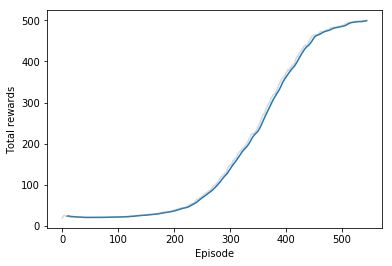

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

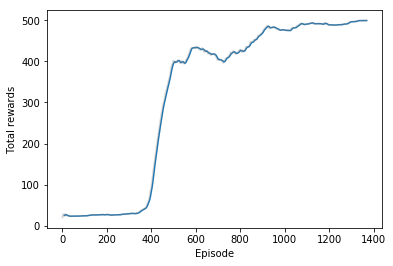

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

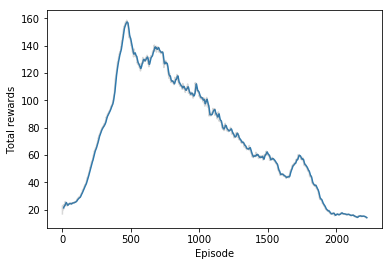

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

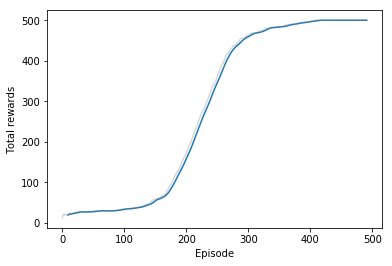

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

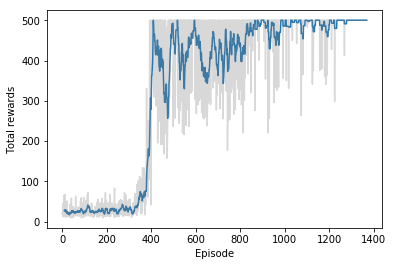

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

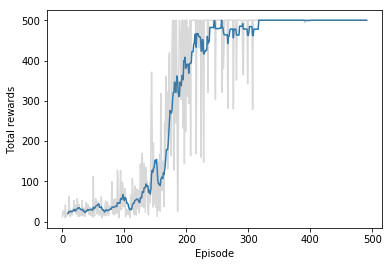

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

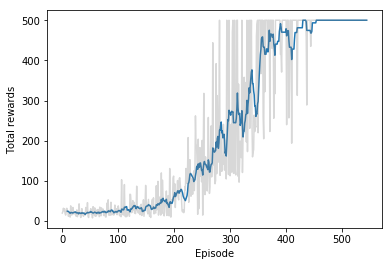

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.